## Introduction

A widely stated (and disputed) result is the "10 days" rule — that if an investor were to exclude the best 10 days in market history then the stock market would be a horrible investment, and conversely, excluding the worst 10 days in market history would make it fantastic. Seyhun [1] visualized this result with various levels of outlier exclusion: 

<img src="imgs/Seyhun-viz.png">

Regardless of the degree to which such a result is overstated or relies on faulty assumptions, it is clear that evaluating tail end risks (and rewards) are crucial to understanding the success of financial strategies and institutions. Such "Black Swan" or "Tail End" events may be responsible for the vast majority of returns and losses on a given strategy. 

In this notebook, I hope to illustrate some examples of how tail end risk can affect investment strategies the way they're traditionally understood, particularly with regards to signal usage and hedge funds. In particular, I will touch upon how the hedge fund payout structure will even 

## Why is it hard to predict tail ends (using signals)? Or, "Correlation Shmorrelation" 

Assume we have a fund, Tail Capital that focuses on predicting tail end events. It develops a signal $X$ that has above $\rho_{threshold}$ correlation on back-tested returns $Y$, and then trades in proportion to the strength of that signal. 

As a few simplifying assumptions, let: 
1. The signal $X$ is normally distributed with 0 mean and standard deviation 1: $X \sim N(0, 1)$
2. The daily return $Y$ is additive and also normally distributed with 0 mean and standard deviation 1: $Y \sim N(0, 1)$
3. $X$ and $Y$ have a correlation of $\rho$, that is: $\frac{E[(X - \mu_{X})(Y - \mu_{Y})]}{\sigma_{X} \sigma_{Y}} = E[X Y] = 1$

**(Note that this normality assumption often used in financial models may also itself be violated by certain tail risk challenges, but we will ignore this for now.)**

We wish to assess the conditional probability that $Y > K$ given that $X > K$, that is:

$P(Y > K | X > K) = \frac{P(X > K, Y > K)}{P(X > K)}$

Another interpretation of this expression is that this is the ratio of the probability of both $X$ and $Y$ exceeding some threshold $K$ assuming correlation $\rho$ over the probability of both $X$ and $Y$ exceeding $K$ assuming correlation $1$ (given that if the correlation is 1, then $P(X > K, Y > K) = P(X > K)$. Taleb calls this the "proportion of certainty."

The evaluation of this expression (Taleb [2]) is performed as follows: 

<img src="imgs/taleb1.png">

The interpretation here is that for tail end events, i.e. when $K$ is many standard deviations away from $0$, a signal is almost meaningless in terms of telling us the odds that the output variable returns, $Y$, are also greater than $K$ unless the correlation $\rho$ is very close to 1.

In the words of Taleb, "Correlation between X and Y carries disproportionate information  for the ordinary, and practically no information for the tails." As an illuminating example, assuming IQ is the signal and intelligence is the output, one would need something resembling $\rho > 0.98$ to 'explain' genius with greater than 50% confidence.

## A Simulated Example

Assume Tail Capital uses a highly leveraged strategy to capitalize on tail end predictions (i.e. by buying out of money puts). We evaluate, at different levels of correlation, what are the actual odds that Tail Capital actually lands on its predictions. 

Assume a naive strategy of buying the OOM option corresponding a thresholded signal (i.e. if our threshold is 3$\sigma$ and the signal crosses 3$\sigma$, then buy the put at 3$\sigma$). We evaluate the probability that our option reaches the exercise price at various level of $\sigma$ and $\rho$. 

We first sample our priors from a $N(0, 1)$ distribution, then multiply our $(X, Y)$ matrix by the Cholesky factorization of the correlation matrix to embed the correlational dependence.

In [49]:
%matplotlib inline

Text(0.5,1,'Probability of Reaching Threshold Price @ Std Dev Threshold')

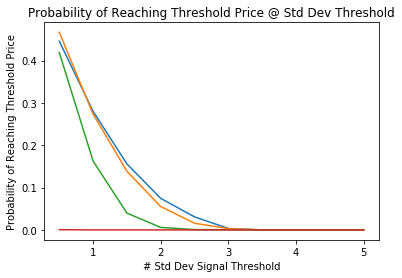

In [61]:
import numpy as np
from scipy.linalg import eigh, cholesky
import matplotlib.pyplot as plt

np.random.seed(42)

mu = 0
sigma = 1
num_trading_days = 100000
std_vals = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

# Sampling various values of correlation, rho
for rho in [0.4, 0.6, 0.8, 0.99]:
    std_signal_landing_pct = []
    
    # Sampling various standard deviations to try to predict the output variable at
    for n_std in std_vals:
        # Initialize the "prior" of X, Y to be a normal distribution centered around 0 with standard deviation 1
        M = np.random.normal(mu, sigma, (num_trading_days, 2))

        # Use the Cholesky Factorization of R, the correlation matrix, to sample X and Y
        R = np.array([[1, rho], [rho, 1]]);
        L = cholesky(R, lower=True)
        M = np.dot(M, L)
        X = M[:, 0]
        Y = M[:, 1]

        # What percent of the time does our signal at n std out actually predict a price at n std out?
        num_signal_fired = 0
        num_correct_predictions = 0
        for (x, y) in zip(X, Y):
            if x > n_std:
                num_signal_fired += 1
                if y > n_std:
                    num_correct_predictions += 1
            elif x < -n_std:
                num_signal_fired += 1
                if y < -n_std:
                    num_correct_predictions += 1
                    
        # Append the number of times, at correlation rho, our signal thresholded at std_val
        # correctly predicts the price at least the same number of standard deviations out
        if num_signal_fired == 0:
            std_signal_landing_pct.append(0)
        else:
            std_signal_landing_pct.append(num_correct_predictions / num_signal_fired)
    
    plt.plot(std_vals, std_signal_landing_pct)
plt.xlabel('# Std Dev Signal Threshold')
plt.ylabel('Probability of Reaching Threshold Price')
plt.title('Probability of Reaching Threshold Price @ Std Dev Threshold')
    

The interpretation here is that once we try to predict our output variable, the price, at more than 3 standard deviations out, our signal becomes practically useless. The decay of our signal corresponding to the tail end also appears to be exponential. 

## Why Hedge Funds are incentivized to practice Bad Tail end Risk Management?

Simply put, this is because hedge funds are paid annually on both a flat and commission fee basis, and do not symmetrically suffer the downside of losing their investors money (beyond firm 'blowup' at a certain threshold). Thus, a hedge fund manager may be incentivized to make asymmetric high probability of return but huge downside bets, thus becoming an optimization problem of maximizing *time* to losses rather than maximizing *returns*. As mentioned in class, they may be incentivized to simply sell very out of money options every year and hope that by the time there's a year that the strike prices hit, they're retired by then. 

## A Contrived Example

Let us simulate hedge fund managers as operating under the following (made-up) incentive structure: 
1. They get paid a flat rate of 1 dollar a year.
2. They get paid a 20% commission of their net profit.
3. The fund shuts down if it has a year where it loses 10 dollars (it will shoulder 20% of this loss). The fund continuously runs until it gets shut down. 

To immediately see an issue with such a (contrived) incentive structure, consider 2 different (contrived) yearly strategies.   

A) 99% of gaining +10, 1% chance of losing for -1000   
B) 80% chance of gaining +10, 20% chance of losing for -10

We can calculate that the yearly expected value for A is:   
$0.99 * 10 - 0.01 * 1000 = -0.1$   

And for B is:   
$0.8 * 10 - 0.2 * 10 = +6$   

It is fairly obvious that strategy A has higher expected returns thn strategy B. But, what is the expected payout to a hedge fund manager?

We can recursively calculate this expected utility based on the fact that if one of these strategies has a winning year, then it is as if the manager starts again fresh from the next year, with the payout from the previous year in the bank.

$E[Strategy] = Flat Rate + Prob Winning Year (Commission Rate * Winning Payout +  E[Strategy])    
+ Prob Losing Year * (Commision Rate * Losing Payout)$   

$E[A] = 1 + 0.99 * ((0.2 * 10) + E[A]) + 0.01 * (0.2 * -1000)$  
$E[A] = +98$   

$E[B] = 1 + 0.8 * ((0.2 * 10) + E[B]) + 0.2 * (0.2 * -10)$   
$E[B] = +11$

Although Strategy A is far more risky (in terms of maximum possible loss) AND has lower expected value to investors, it has much higher expected payout to the hedge fund manager!

## Simulated Investment Hedge Fund Strategies

Let us define an investment strategy as a yearly distribution (summing to 1) of probability of integer payouts in the range $[-100, 100]$. We will simulate according to the same rules above, and evaluate both the expected value of a strategy and the expected utility to a hedge fund manager. We will also add a constraint that a fund will never exist for more than 100 years. 

We will sample the strategies, seeing the relationship between the expected value of the strategy and hedge fund manager payout; and see if the skewness (i.e. existence of tails) in the strategy has any relationship with payout above expectation. 

In [114]:
import scipy.stats

max_returns = 100

# Gets expected value from relative weights by performing -20 * P(return of -20) + -19 * P(return of -19, etc.) + ...
def get_expected_value_from_relative_weights(relative_weights):
    return sum(i * w for i, w in zip([i for i in range(-max_returns, max_returns+1)], relative_weights))

def simulate_investment_fund_payout(relative_weights):
    payout = 0
    
    # Maximum of 100 years
    for i in range(100):
        payout += 1 # Add 1, the fixed management fee 
        
        # Sample yearly return from [-20, 20] based on the relative weights distribution 
        yearly_return = np.random.choice([i for i in range(-max_returns, max_returns+1)], 1, list(relative_weights))[0]
        
        # Add the 20% commission
        payout += 0.2 * yearly_return
        
        # If it has a -10 or worse losing year, the fund ends
        if payout <= -10:
            return payout
    return payout

expected_values = []
average_payouts = []
skewness = []

for i in range(100):
    # Get relative weights from each [-20, 20] value from a uniform [0, 1] distribution,
    # such that they sum to 1
    relative_weights = np.random.random(2*max_returns + 1)
    relative_weights /= np.sum(relative_weights)
    
    # Calculate expected value for investors from the randomly sampled investment strategy
    ev = get_expected_value_from_relative_weights(relative_weights)
    expected_values.append(ev)
    
    # Calculated expected payotut for hedge fund managers
    simulated_payouts = []
    for j in range(10):
        simulated_payouts.append(simulate_investment_fund_payout(relative_weights))
        
    average_payouts.append(np.mean(simulated_payouts))
     
    # Calculate the skewness of the investment strategy distribution
    skewness.append(scipy.stats.skew(relative_weights))

Text(0.5,1,'Hedge Fund Manager Payout vs. Strategy Yearly Expected Value')

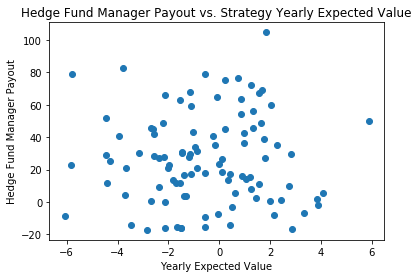

In [122]:
x = expected_values
y = average_payouts
plt.scatter(x, y)
plt.xlabel('Yearly Expected Value')
plt.ylabel('Hedge Fund Manager Payout')
plt.title('Hedge Fund Manager Payout vs. Strategy Yearly Expected Value')

Here we see that the expected value of a strategy in this setup has a weak at best relationship with how much a hedge fund manager can expect to be paid from the strategy.

We use skewness as a proxy for how fat the tails of the strategy return distribution are. Mathematically, skewness is defined as:

<img src="imgs/skewness.png">

Text(0.5,1,'Hedge Fund Manager Payout vs. Skewness')

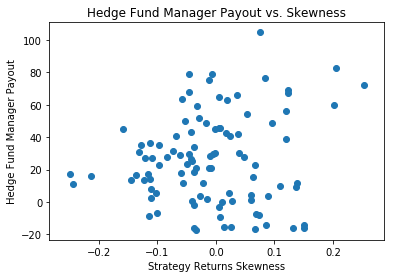

In [129]:
plt.scatter(skewness, average_payouts)
plt.xlabel('Strategy Returns Skewness')
plt.ylabel('Hedge Fund Manager Payout')
plt.title('Hedge Fund Manager Payout vs. Skewness')

Note that now get a much tighter relationship between investment strategy skewness to hedge fund manager payout than yearly expected value! This implies that under our contrived setup, **hedge fund managers are incentivized to pursue strategy with more tail end risk**, to "accumulate bonuses before eventual "blowup" for which he does not have to repay previous compensation [and] make a series of asymmetric bets (high probability of small profits, small probability of large losses) below their probabilistic fair value" (Taleb [3])

## Conclusions

We have demonstrated that
1) Using correlation via signals may be inappropriate for identifying tail end returns    
2) Hedge fund managers have perverse incentives to maintain high probability of profit even at the risk of extreme tail end downside

The solution to the problem is unclear, but likely lies in a 

## References

1. STOCK MARKET EXTREMES AND PORTFOLIO PERFORMANCE. A study commissioned by Towneley Capital Management and conducted by Professor H. Nejat Seyhun, University of Michigan. 1993. http://www.towneley.com/wp-content/uploads/2016/01/Research.-TCM-Mkt-Timing-Study-1993.pdf
2. Nassim Taleb's Twitter. https://twitter.com/nntaleb/status/1135116646442590208. 2019
3. "Why did the Crisis of 2008 Happen?" Nassim Taleb. 2010. 